# Finding patterns in signals using Optimal Transport and Dynamic Time Warping

In this example we will compare different distances when used as the inner metric in a dynamic time-warping of spectrograms.
Setup

In [64]:
using DynamicAxisWarping, SpectralDistances, LPVSpectral, DSP, Plots, Statistics, BenchmarkTools, Distances, Random, ThreadTools, AlphaStableDistributions, SlidingDistancesBase
gr();
Random.seed!(0);

We start by creating a short patter, the *query*, we then create a long time series that contains a quite similar sound, but where the frequencies of the chirp are slightly higher. This is a realistic scenario when doing, e.g., acoustic detection. Different individuals within the same animal species might have similar calls, but slightly different pitch etc. We also add some alpha sub-gaussian noise in order to make the problem a bit harder.

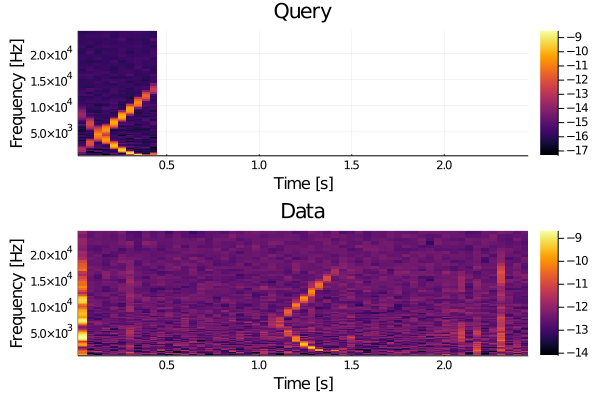

In [65]:
plot    = Plots.plot
N       = 48_000 ÷ 2
nfft    = 4096
f1      = range(0.01, stop = 1, length = N)
f2      = range(1, stop = 0.1, length = N) .^ 2
g(x, N) = exp(-10 * (x - N / 2)^2 / N^2)
t       = 1:N
y10     = (sin.(t .* f1) .+ sin.(t .* (f2 .+ 0.4))) .* g.(t, N)
y20     = (sin.(t .* (f1 .+ 0.5)) .+ sin.(t .* (f2 .+ 0.5))) .* g.(t, N)
q       = Float32.(y10 .+ 0.2 .* randn.())
y       = Float32.([0y20; 0y20; y20; 0y20; 0y20] .+ 1 .* randn.())
y     .+= v1(rand(AlphaSubGaussian(n=length(y))));

Q = melspectrogram(q, nfft, window = hanning, fmin = 400, fs = 48_000)
Y = melspectrogram(y, nfft, window = hanning, fmin = 400, fs = 48_000)
plot(plot(Q, title = "Query"), plot(Y, title = "Data"), link = :both, layout = (2, 1), yscale=:identity)

We now see if we can detect the pattern using DTW with the standard squared Euclidean distance

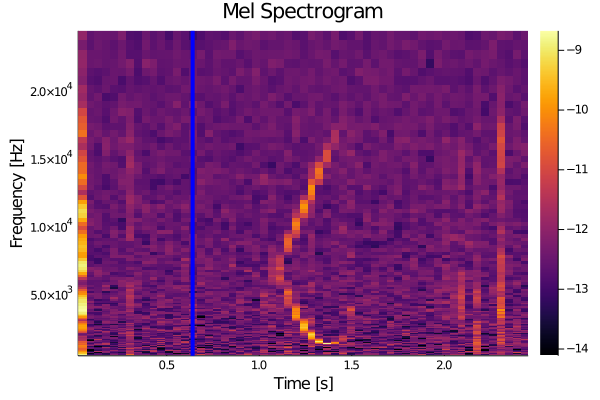

In [66]:
rad  = 10 # This is the maximum allowed warping radius
dist = SqEuclidean()
w    = DTWWorkspace(sqrt.(Q.power), dist, rad)
res  = dtwnn(w, sqrt.(Y.power))
plot(Y);
vline!([Y.time[res.loc]], l = (4, :blue), primary=false, yscale=:identity)

That did probably not go well at all! The line indicates where the smallest distance to the pattern was, i.e., where the nearest neighbor search thinks the *onset* of the pattern is.

Let's do the same with a transport-based distance

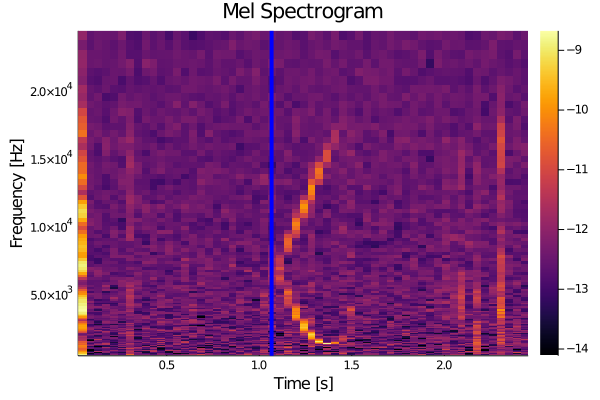

In [67]:
n, m = size(Q.power)
dist = DiscreteGridTransportDistance(Cityblock(), Float32, n, n)
w    = DTWWorkspace(sqrt.(Q.power), dist, rad, Val(Nothing))
res  = dtwnn(w, sqrt.(Y.power))
plot(Y);
vline!([Y.time[res.loc]], l = (4, :blue), primary=false, yscale=:identity)

The line should now be a better indication of the onset of the pattern

Next, we plot the cost function for each time shift to see how they behave

  34.269 ms (109 allocations: 50.88 KiB)
  186.281 μs (109 allocations: 50.83 KiB)


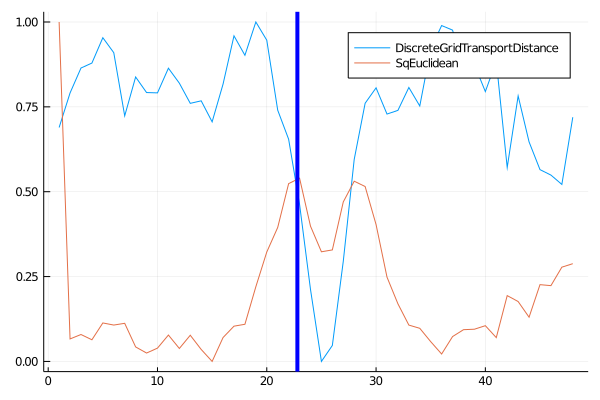

In [68]:
function naive(a, b, dist = SqEuclidean(), r = 7)
    dists = map(1:lastlength(b)-lastlength(a)+1) do i
        dtw_cost(a, getwindow(b,lastlength(a),i), dist, r)
    end
end

plot()
for dist in [DiscreteGridTransportDistance(Cityblock(), Float32, n, n), SqEuclidean()]
    res = @btime naive($sqrt.(Q.power), $sqrt.(Y.power), $dist, $rad)
    res .-= minimum(res)
    res ./= maximum(res)
    plot!(res, lab = string(typeof(dist).name))
end
fig1 = vline!([2 * size(Y.power, 2) / 5], l = (4, :blue), primary=false)

The Euclidean distance is rather terrible for this task. The transport based distance seems to be doing the right thing.

unfortunately, calculating this using the transport-based distance takes quite a while, about 35ms in this case. While that might not seem like much, the data we're searching through only corresponds to this many seconds, if the sample rate is 48kHz

In [69]:
length(y) / 48000

2.5

We are thus intersted in distances that are faster to compute. We'll explore the OTRD distance, which performs optimal transport between the roots of a linear-system representation of the signal.

In [70]:
fm  = TimeWindow(inner = LS(na = 8, λ=1e-3), n = nfft, noverlap = nfft÷2)
Qm  = fm(q) |> change_precision(Float64)
Ym  = fm(y) |> change_precision(Float64);

Let's see how the world looks like through the lens of autoregressive models

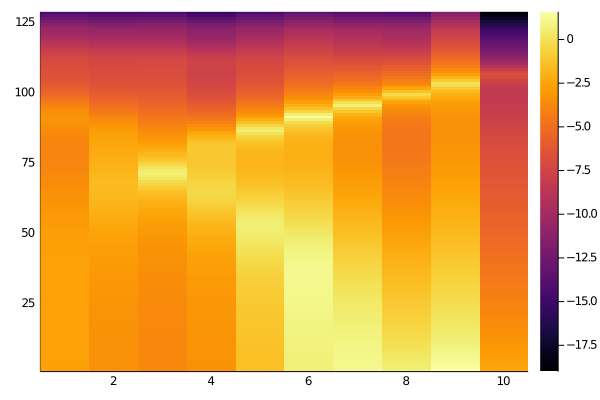

In [71]:
plot(Qm, LPVSpectral.mel_to_hz(Q.mels)./48000, rad=false, yscale=:identity)

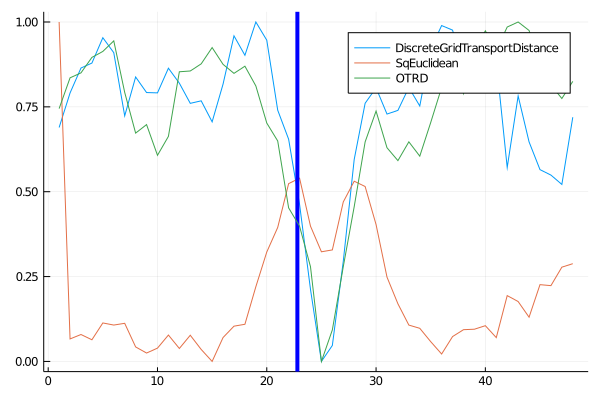

In [72]:
dist  = OptimalTransportRootDistance(p = 1, β = 0.5)
distf = (x, y) -> evaluate(dist, x, y, tol = 1e-3)
res   = naive(Qm.models, Ym.models, distf, rad)
res .-= minimum(res)
res ./= maximum(res)
plot!(fig1, res, lab = "OTRD")

This should do an okay job, but is it fast?

In [73]:
w = DTWWorkspace(Qm.models, distf, rad)
@btime dtwnn($w, $(Ym.models), prune_endpoints=false);

  110.878 ms (417513 allocations: 41.75 MiB)


## Notes on performance improvements
Searching for the nearest neighbor using DTW tends to become relatively cheaper the longer the data searched through is. This is due to pruning heauristics that abort the search early based on the smallest distance found so far.
The main thing to watch out for is the length (in time) of the query sequence. Using a larger `nfft` effectively reduces the time resolution which greatly reduces the time-complexity, 𝒪(t²) if pruning heuristics are not effective.

### Future work
The mass normalization for spectrograms has to be improved. Currently, each spectrum (per time point) is normalized to sum to one. A perhaps better strategy is to normalize the entire spectrogram and then use unbalanced mass transport per time point.

# Transport in time
We can also consider using optimal transport along the time axis instead of DTW. Let's do the same stuff as above for the TimeDistance from SpectralDistances.jl

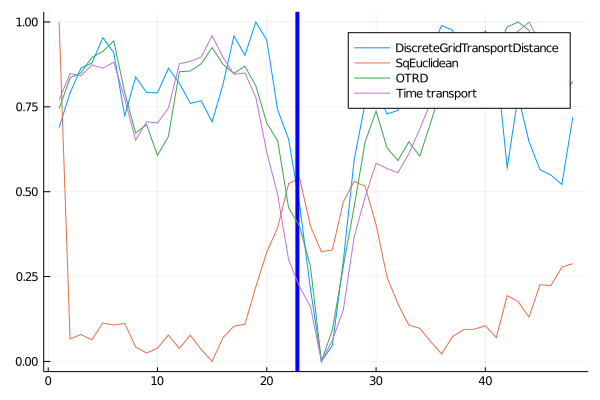

In [74]:
dist = TimeDistance(inner=OptimalTransportRootDistance(p=1, β=0.5),tp=1,c=0.1)
res   = SpectralDistances.distance_profile(dist, Qm, Ym)
res .-= minimum(res)
res ./= maximum(res)
plot!(fig1, res, lab = "Time transport")

In [75]:
function naive_time(a, b, dist)
    n = length(a)
    dists = map(1:length(b.models)-length(a.models)) do i
        Y = TimeVaryingAR(b.models[i:i+length(a.models)-1])
        dist(a, Y, tol=1e-3, check_interval=2)
    end
end
@btime naive_time($Qm, $Ym, $dist);
@btime SpectralDistances.distance_profile($dist, $(change_precision(Float32,Qm)), $(change_precision(Float32,Ym)), check_interval=5);

  16.252 ms (11848 allocations: 8.33 MiB)
  11.095 ms (1978 allocations: 248.36 KiB)


It appears to be surprisingly competitive, both in terms of accuracy and performance, even though it's evaluated using a rather naive method.